# Aprendizaje no supervisado

La mayor parte de lo que hacemos en este curso es aprendizaje supervisado: dado $x$, intenta predecir $y$. 
Aquí empezamos a estudiar algoritmos no supervisados donde intentamos descubrir que valores toma nuestra variable de interes $y$


El clustering se utiliza en una gran variedad de aplicaciones, entre ellas 

1. **Para la segmentación de clientes**

    Puede agrupar a sus clientes en función de sus compras y su actividad en su sitio web. Esto es útil para entender quiénes son sus clientes y qué necesitan, de modo que pueda adaptar sus productos y campañas de marketing a cada segmento. Por ejemplo, la segmentación de clientes puede ser útil en los sistemas de recomendación para sugerir contenidos que otros usuarios del mismo clúster disfrutaron.


2. **Para el análisis de datos**

    Cuando se analiza un nuevo conjunto de datos, puede ser útil ejecutar un algoritmo de clustering y luego analizar cada cluster por separado.


3. **Como técnica de reducción de la dimensionalidad**

    Una vez que se ha agrupado un conjunto de datos, suele ser posible medir la afinidad de cada instancia con cada clúster (la afinidad es cualquier medida de lo bien que encaja una instancia en un clúster). El vector de características x de cada instancia puede sustituirse por el vector de afinidades de su clúster. Si hay k clusters, este vector es k-dimensional. Este vector es típicamente mucho menos dimensional que el vector de características original, pero puede preservar suficiente información para el procesamiento posterior.


4. **Para la detección de anomalías (también llamada detección de valores atípicos)**

    Cualquier instancia que tenga una baja afinidad con todos los clusters es probable que sea una anomalía. Por ejemplo, si ha agrupado a los usuarios de su sitio web en función de su comportamiento, puede detectar usuarios con un comportamiento inusual, como un número inusual de solicitudes por segundo. La detección de anomalías es especialmente útil para detectar defectos en la fabricación, o para la detección de fraudes.


5. **Para el aprendizaje semisupervisado**

    Si sólo tiene unas pocas etiquetas, puede realizar un clustering y propagar las etiquetas a todas las instancias del mismo cluster. Esta técnica puede aumentar en gran medida el número de etiquetas disponibles para un algoritmo de aprendizaje supervisado posterior, y así mejorar su rendimiento.


6. **Para los motores de búsqueda**

    Algunos motores de búsqueda permiten buscar imágenes similares a una imagen de referencia. Para construir un sistema de este tipo, primero se aplicaría un algoritmo de agrupación a todas las imágenes de la base de datos; las imágenes similares acabarían en el mismo grupo. Entonces, cuando un usuario proporcione una imagen de referencia, todo lo que hay que hacer es utilizar el modelo de clustering entrenado para encontrar el cluster de esta imagen, y entonces se puede simplemente devolver todas las imágenes de este cluster.


7. **Para segmentar una imagen**
    
    Agrupando los píxeles según su color, y sustituyendo luego el color de cada píxel por el color medio de su cluster, es posible reducir considerablemente el número de colores diferentes en la imagen. La segmentación de imágenes se utiliza en muchos sistemas de detección y seguimiento de objetos, ya que facilita la detección del contorno de cada objeto.

## Cargar los paquetes a usar

En primer lugar, vamos a importar algunos módulos comunes, asegurarnos de que MatplotLib traza las figuras en línea y preparar una función para guardar las figuras. 

In [7]:
import numpy as np
import pandas as pd
import random

from sklearn import datasets
from scipy.spatial import distance
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import Ellipse, Polygon



### Carguemos nuestro conjunto de datos de viviendas.





*   Esta vez NO voy a hacer una división entrenamiento-prueba.
*   Puede haber razones para seguir haciéndolo, depende.
* Tampoco voy a separar en X e y

In [3]:
housing_df = pd.read_csv("data/housing.csv", index_col=1)


In [4]:
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']

numeric_features += ['SalePrice'] # treat this as a regular numeric feature here!!!

In [5]:
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(housing_df.columns) - set(numeric_features) - set(ordinal_features_reg))

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex']

In [6]:
numeric_preprocessing = make_pipeline(SimpleImputer(strategy='median'), 
                                      StandardScaler())
ordinal_preprocessing = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                                      OrdinalEncoder(categories=[ordering]*len(ordinal_features_reg)))
categorical_preprocessing = make_pipeline(SimpleImputer(strategy='constant', fill_value="?"),
                                          OneHotEncoder(handle_unknown='ignore', sparse=False))

In [7]:
preprocessing = ColumnTransformer([
    ('numeric', numeric_preprocessing, numeric_features),
    ('ordinal', ordinal_preprocessing, ordinal_features_reg),
    ('categorical', categorical_preprocessing, categorical_features)
])

In [8]:
preprocessing.fit(housing_df);

In [9]:
preprocessing.fit(housing_df);
ohe_columns = list(preprocessing.named_transformers_['categorical'].named_steps['onehotencoder'].get_feature_names(categorical_features))
new_columns = numeric_features + ordinal_features_reg + ohe_columns

In [10]:
housing_df_enc = pd.DataFrame(preprocessing.transform(housing_df), index=housing_df.index, columns=new_columns)
housing_df_enc.shape

(1460, 1745)

## Podemos dividir estas 1460 casas en grupos similares? 

Queremos agrupar las observaciones de forma que
* Los ejemplos del mismo grupo sean lo más parecidos posible;
* Los ejemplos de los distintos grupos sean lo más diferentes posible.

Ejemplo de las salas 

## Clasificación vs. Clustering


Aunque se acerca a la idea de clasificación, el clustering es no supervisado, es decir, las etiquetas son desconocidas.
* No tiene sentido pensar en un cluster "verdadero" o "correcto"; lo mejor que podemos hacer es hablar de cluster óptimo (en cierto sentido).
* En general, ni siquiera se conoce el número de clusters.

¿Cuántos tipos de salsa de espaguetis debemos hacer?

In [11]:
## Wine dataset
wine = datasets.load_wine()
data_wine = pd.DataFrame(wine.data, columns=wine.feature_names) 
data_wine['target'] = wine.target_names[wine.target]

## Iris dataset
iris = datasets.load_iris() # loading the iris dataset
features = iris.data # get the input data
labels = iris.target_names[iris.target] # get the responses, in this case the specie of the flowers

# Reducing the dimensionality for plotting purposes 
pca = PCA(n_components=2) 
pca.fit(features)
data_iris = pd.DataFrame(pca.transform(features), columns=['$Z_1$', '$Z_2$'])
data_iris['target'] = labels

In [12]:
def plot_sup_x_unsup(data, w, h):
    """
        Function to generate a supervised vs unsupervised plot.
        Parameters:
        -----------
        data: pd.DataFrame
            A pandas dataframe with X1 and X2 coordinate, and a target column
            for the classes.
        w: int
            Width of the plot
        h: int
            height of the plot
    """
    # Colors to be used (upt to 5 classes)
    colors = np.array(['black', 'blue', 'red', 'green', 'purple'])

    # Getting the column and classes' names
    col_names = data.columns.to_numpy()
    target_names = data['target'].to_numpy()

    # Getting numerical values for the classes labels
    target = np.unique(data['target'].to_numpy(), return_inverse=True)

    # Getting X1 and X2
    data = data.iloc[:, 0:2].to_numpy()

    # Creates the Figure
    plt.figure(0, figsize=(w, h))

    # Create two subplots
    plt.subplots_adjust(right=2.5)

    # Get the first subplot, which is the Supervised one.
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    for i, label in enumerate(target[0]):
        plt.scatter(data[target_names == label, 0],
                    data[target_names == label, 1],
                    c=colors[i], label=label)

    # Creates the legend
    plt.legend(loc='best', fontsize=22, frameon=True)

    # Name the axes and creates title
    plt.xlabel(col_names[0], fontsize=1.5*(w + h))
    plt.ylabel(col_names[1], fontsize=1.5*(w + h))
    plt.title("Supervised", fontdict={'fontsize': 2 * (w + h)})

    ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
    ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})

    # Creates the unsupervised subplot.
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    plt.scatter(data[:, 0], data[:, 1])
    plt.title("Unsupervised", fontdict={'fontsize': 2 * (w + h)})
    plt.xlabel(col_names[0], fontsize=1.5*(w + h))
    plt.ylabel(col_names[1], fontsize=1.5*(w + h))
    ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
    ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})




C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/455481481.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/455481481.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})
C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/455481481.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w + h})
C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/455481481.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w + h})


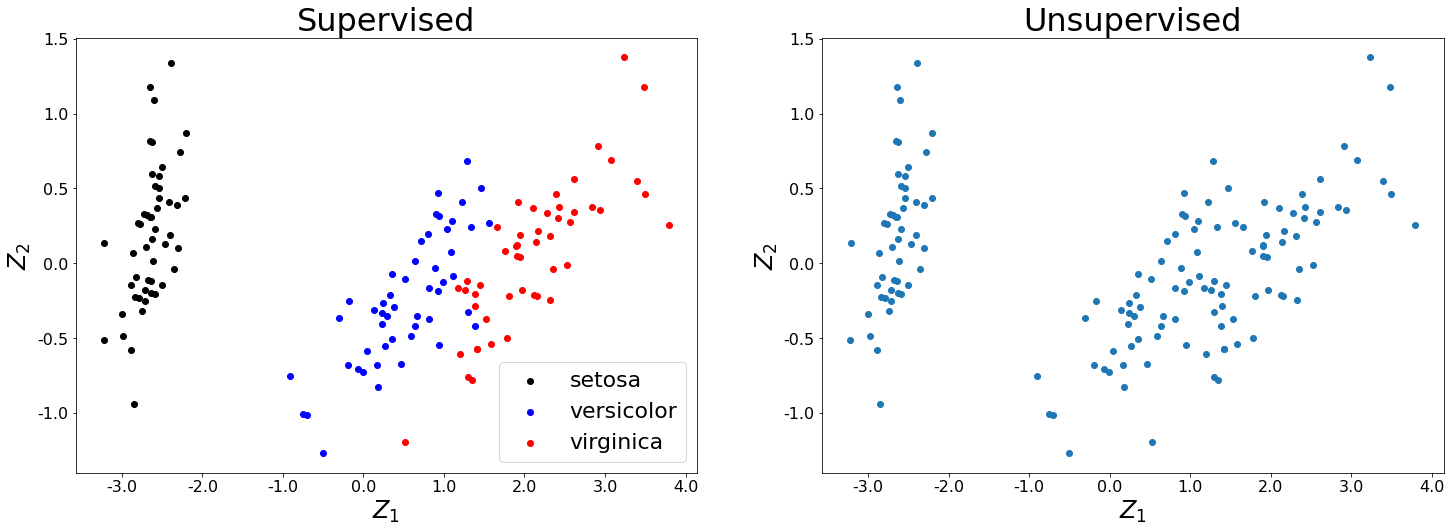

In [13]:
plot_sup_x_unsup(data_iris, 8, 8)

In [14]:
def plot_unsup(data, w, h, title=None):
    """
    Function to generate unsupervised plot.
    Parameters:
    -----------
    data: pd.DataFrame
        A pandas dataframe with X1 and X2 coordinate. If more than two
        coordinates, only the first two will be used.
    w: int
        Width of the plot
    h: int
        height of the plot
    title: str
        the tile of the plot
    """

    plt.figure(figsize=(w, h))
    ax = plt.gca()
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
    plt.title(title, fontdict={'fontsize': 1.2*(w + h)})
    plt.xlabel(data.columns[0], fontsize=1.2*w)
    plt.ylabel(data.columns[1], fontsize=1.2*w)
    ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w})
    ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w})

C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/260296250.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict={'fontsize': w})
C:\Users\Usuario\AppData\Local\Temp/ipykernel_16220/260296250.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict={'fontsize': w})


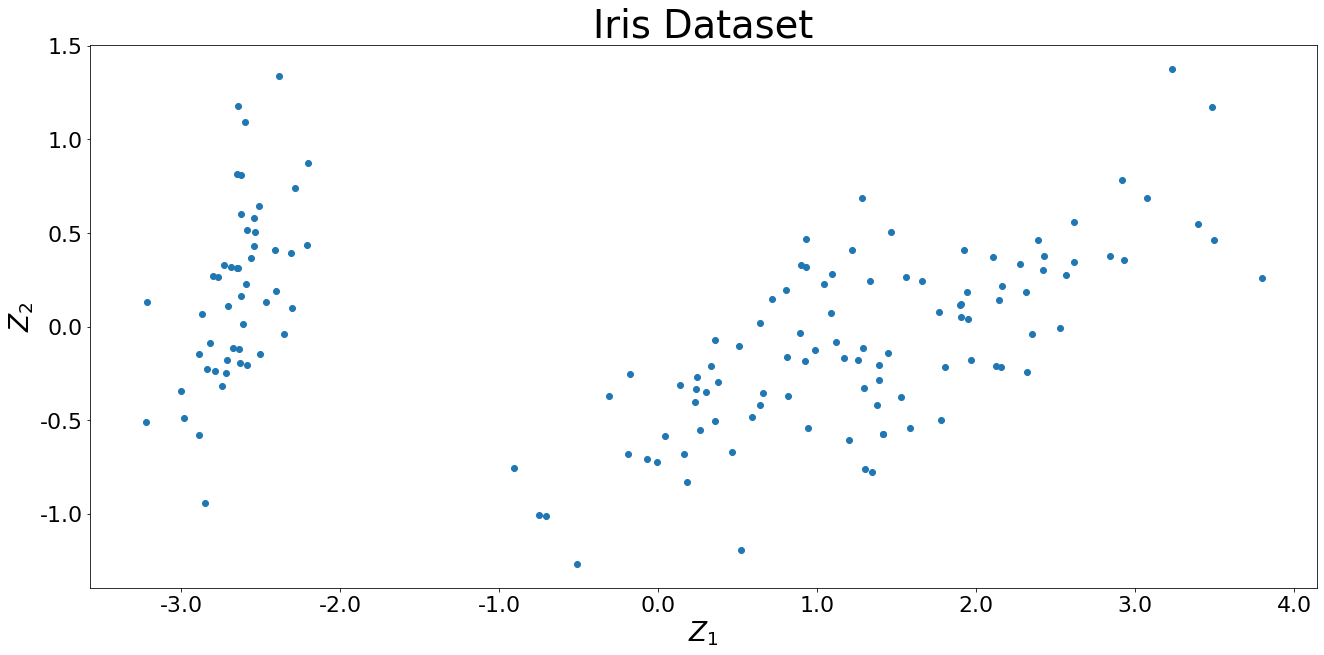

In [15]:
plot_unsup(data_iris, 22, 10, "Iris Dataset")

## Algoritmo

Este se compone de dos partes:

Asignar cada ejemplo al centro más cercano.
1. Estimar los nuevos centros como la media de los ejemplos en un cluster.
2. Repetir 1. y 2. hasta que los centros y las * asignaciones no cambien más.

En el $k-means$ el número de clusters, $k$, es un hiperparámetro.

In [16]:
iris_2d = data_iris.iloc[:,:2]
iris_2d.head()

,$Z_1$,$Z_2$
0,-2.684126,0.319397
1,-2.714142,-0.177001
2,-2.888991,-0.144949
3,-2.745343,-0.318299
4,-2.728717,0.326755


In [17]:
kmeans = KMeans()
kmeans.fit(iris_2d); # only pass in one argument because this is unsupervised learning

In [18]:
clusters = kmeans.predict(iris_2d)

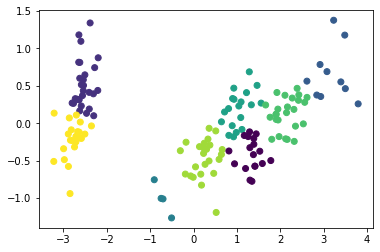

In [19]:
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);

In [20]:
?KMeans

### Comentarios

El k-means "clásico" es aleatorio y puede dar malos resultados.

Adicionalmente, vale la pena resaltar que el ***fit*** hace dos cosas:
* Asigna cada punto a un cluster
* Crea un "centro de cluster" para cada punto
* Los niveles que se crea son arbitrarios

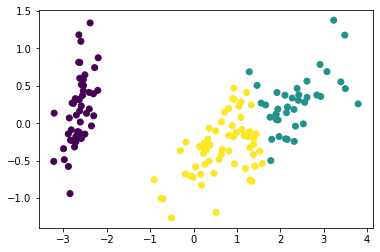

In [21]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(iris_2d);
clusters = kmeans.predict(iris_2d)
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);

In [22]:
kmeans.predict(iris_2d)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

In [23]:
kmeans.cluster_centers_

array([[-2.64241546,  0.19088505],
       [ 2.34652659,  0.27393856],
       [ 0.66567601, -0.3316042 ]])

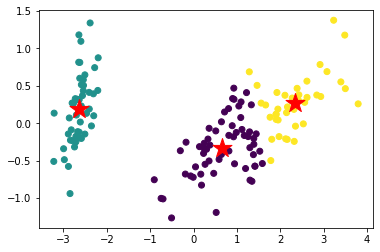

In [24]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(iris_2d);
clusters = kmeans.predict(iris_2d)
plt.scatter(iris_2d.iloc[:,0], iris_2d.iloc[:,1], c=clusters);
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='*', c="r", s=400);

In [25]:
kmeans.predict(np.zeros((1,2)))

array([0])

Arriba podemos ver el centro de cada clúster.

* KMeans es un algoritmo de clustering (aprendizaje no supervisado)
* La entrada es el marco de datos, la salida es la asignación de cada punto a un clúster
* NearestNeighbors toma un punto y encuentra los puntos más cercanos
* KNeighborsClassifier y KNeighborsRegressor son para el aprendizaje supervisado
* Utilizan los vecinos más cercanos para predecir una etiqueta.

### Podriamos predecir con kmeans ?

## Desarrollando el ejemplo con los datos de las viviendas.

Ha quedado claro que podemos hacer predicciones, por tanto podemos dividir el data set en entrenamiento y prueba.

Aquí no se hace, pero queda invitado a intenarlo.

In [26]:
housing_df_enc.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,RoofStyle_Mansard,RoofStyle_Shed,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8
MSSubClass,,,,,,,,,,,,,,,,,,,,,
60,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
60,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(housing_df_enc);

In [28]:
preds = kmeans.predict(housing_df_enc)
preds

array([2, 1, 2, ..., 2, 1, 1])

In [29]:
housing_raw_clust = housing_df.assign(cluster=preds)
housing_raw_clust

,Id,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,cluster
MSSubClass,,,,,,,,,,,,,,,,,,,,,
60,1,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,2
20,2,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1
60,3,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2
70,4,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1
60,5,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,1456,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,2
20,1457,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,0
70,1458,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,2


In [30]:
housing_raw_clust.query("cluster == 0")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()


YearBuilt        1997.169139
OverallQual         7.249258
SalePrice      240553.554896
GrLivArea        1622.534125
LotArea         12882.275964
dtype: float64

In [31]:
housing_raw_clust.query("cluster == 1")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()


YearBuilt        1950.943226
OverallQual         5.192258
SalePrice      131394.886452
GrLivArea        1247.492903
LotArea          9145.078710
dtype: float64

In [32]:
housing_raw_clust.query("cluster == 2")[["YearBuilt", "OverallQual", "SalePrice", "GrLivArea", "LotArea"]].mean()


YearBuilt        1991.448276
OverallQual         7.005747
SalePrice      233469.428161
GrLivArea        2008.551724
LotArea         11281.051724
dtype: float64

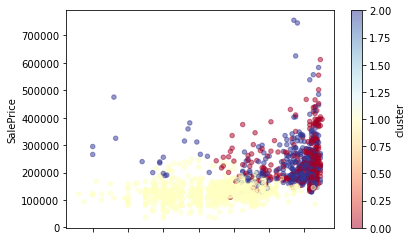

In [33]:
housing_raw_clust.plot.scatter(x="YearBuilt", y="SalePrice", 
                               c="cluster", cmap="RdYlBu", alpha=0.5);

In [34]:
housing_df_enc.shape


(1460, 1745)

In [35]:
housing_df.shape


(1460, 80)

## Elección del numero de clusters: codo 

Como en el aprendizaje no supervisado no tenemos los valores de $y$, resulta muy difícil medir objetivamente la eficacia de los algoritmos.

***No existe un enfoque definitivo.***

Sin embargo, algunas estrategias podrían ser útiles para determinar el numero de clusters.



### El método del codo

Encontrar una medida de lo bien que los clusters "se 
ajustan" a los datos

* La suma de las distancias intraclúster, también conocida como inercia es frecuentemente usada.

* Pregunta: ¿queremos que sea pequeña o grande?

In [36]:
kmeans_sweep_iris = {k : KMeans(n_clusters = k, random_state=1).fit(iris_2d) for k in range(1,10)}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [37]:
def plot_elbow(kmeans_dict, elbow=None, w=11, h=5):
    plt.figure(figsize = (w,h))
    if elbow is not None:
        plt.axvline(x=elbow, linestyle='-.', c="black")
    plt.plot(kmeans_dict.keys(), [km.inertia_ for km in kmeans_dict.values()], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)

63.819942022001285

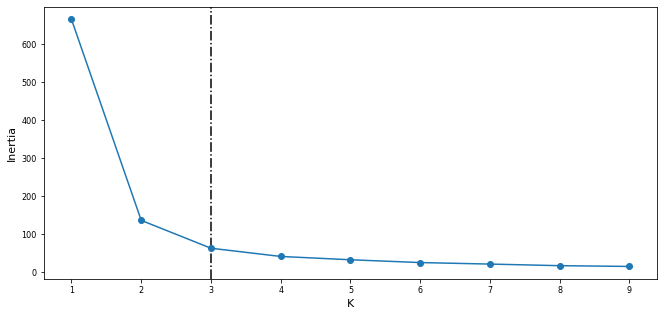

In [38]:
plot_elbow(kmeans_sweep_iris, elbow=3)
kmeans_sweep_iris[3].inertia_

A partir del gráfico anterior, podríamos argumentar que entre dos y tres conglomerados son suficientes.

Y para los datos de la vivienda:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


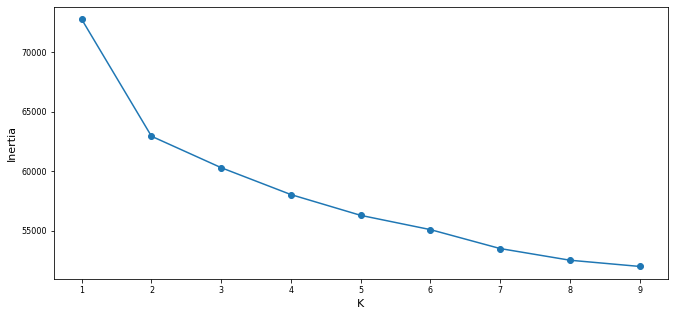

In [39]:
kmeans_sweep_housing = {k: KMeans(n_clusters = k, random_state=1).fit(housing_df_enc) for k in range(1,10)}
plot_elbow(kmeans_sweep_housing)
# We could argue between two and three clusters are enough;

Este es un poco menos claro.

### Método de la silueta

Para la aplicación del método de la Silueta, para ellos debe encontrarse el segundo mejor cluster para cada punto. Estos son los pasos:

> Promediar las distancias del punto verde a los otros puntos del mismo cluster. Estas distancias están representadas por las líneas negras;

> Promediar las distancias del punto verde a los puntos del cluster azul. Estas distancias están representadas por las líneas azules;

> Promedio de las distancias del punto verde a los puntos del cluster rojo. Estas distancias están representadas por las líneas rojas;

> Entonces, como la distancia media al cluster azul es menor que al cluster rojo, el cluster azul se considera el cluster vecino - (la segunda mejor opción para que viva el punto verde, después del cluster negro).

* El método de la silueta compara la distancia media al cluster vecino con la distancia media al cluster bajo analisis para obtener un coeficiente de silueta para ese ejemplo (``sklearn.metrics.silhouette_samples``).

* A diferencia de la inercia, los valores más grandes son mejores porque indican que el punto está más alejado de los clusters vecinos.

* A diferencia de la inercia, la puntuación global de la silueta empeora a medida que se añaden más clusters porque acaba estando más cerca de los clusters vecinos.

* Al igual que con la inercia, no se verá un valor "pico" de esta métrica que indique el mejor número de clusters.

Podemos visualizar la puntuación de la silueta para cada ejemplo individualmente en un gráfico de silueta (de ahí el nombre), véase más abajo.


In [44]:
from sklearn.datasets import make_blobs
def plot_silhouette_dist(w, h):

    n = 30
    df, target = make_blobs(n_samples=n,
                            n_features=2,
                            centers=[[0, 0], [1, 1], [2.5, 0]],
                            cluster_std=.15,
                            random_state=1)

    colors = np.array(['black', 'blue', 'red'])

    plt.figure(figsize=(w, h))
    ax = plt.gca()
    ax.set_ylim(-.45, 1.4)
    ax.set_xlim(-.25, 2.8)
    plt.scatter(df[:, 0], df[:, 1], c=colors[target])

    p = 1
    for i in range(0, n):
        plt.plot((df[p, 0], df[i, 0]), (df[p, 1], df[i, 1]),
                 linewidth=.7, c=colors[target[i]])

    plt.scatter(df[p, 0], df[p, 1], c="lightgreen", zorder=10)

    c1 = plt.Circle((.1, -.12), 0.27, fill=False, linewidth=2, color='black')
    c2 = plt.Circle((1.03, 1.04), 0.27, fill=False, linewidth=2, color='blue')
    c3 = plt.Circle((2.48, 0.1), 0.27, fill=False, linewidth=2, color='red')
    ax.add_artist(c1)
    ax.add_artist(c2)
    ax.add_artist(c3)
    plt.xlabel("X1", fontdict={'fontsize': w})
    plt.ylabel("X2", fontdict={'fontsize': w})
    plt.title("Distances for silhouette", fontdict={'fontsize': w+h})

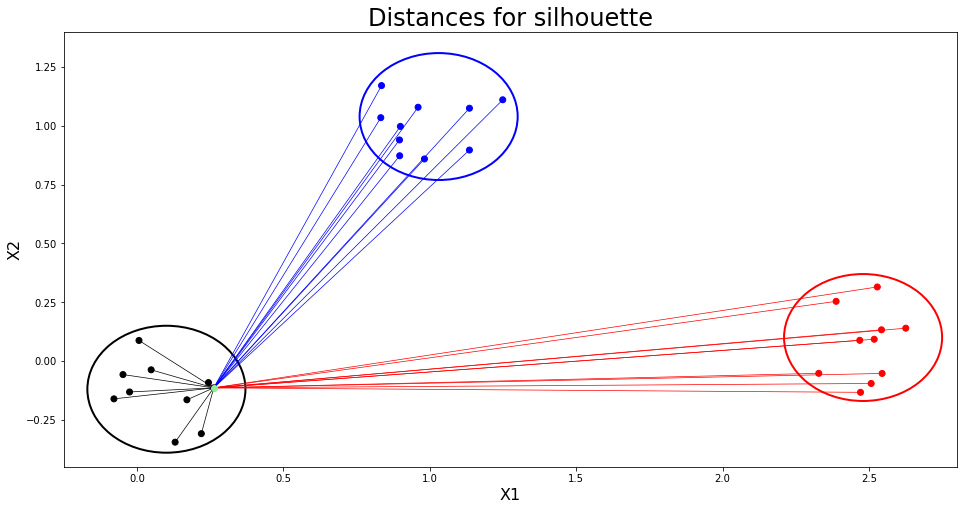

In [45]:
plot_silhouette_dist(16, 8)

In [46]:
# collapse this cell

def make_sklearn_sil_plots(X, params_list=None, clusterer_class=KMeans):

    if params_list is None:
        params_list = [{"n_clusters" : n} for n in range(2,8)]
    
    clusterers = [clusterer_class(**params).fit(X) for params in params_list]
    
    for nn, clusterer in enumerate(clusterers):
        n_clusters = np.max(clusterer.labels_) + 1
        
        # Create a subplot with 1 row and 2 columns
        
        if X.shape[1] == 2:
            fig, (ax1, ax2) = plt.subplots(1, 2)
        else:
            fig, ax1 = plt.subplots(1, 1)

        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#         cluster_labels = clusterer.predict(X)
        cluster_labels = clusterer.labels_

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        if X.shape[1] == 2:
            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                        c=colors, edgecolor='k')

            # Labeling the clusters
            try:
                centers = clusterer.cluster_centers_
            except AttributeError:
                pass
            else:
                # Draw white circles at cluster centers
                ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c="white", alpha=1, s=200, edgecolor='k')

                for i, c in enumerate(centers):
                    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                                s=50, edgecolor='k')

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for " + clusterer_class.__name__ +
                      " with %s" % params_list[nn]),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.7056703225102109
For n_clusters = 3 The average silhouette_score is : 0.597676421954799
For n_clusters = 4 The average silhouette_score is : 0.5591106064519759
For n_clusters = 5 The average silhouette_score is : 0.5496474874145385
For n_clusters = 6 The average silhouette_score is : 0.4494202590737018
For n_clusters = 7 The average silhouette_score is : 0.43220987613066464


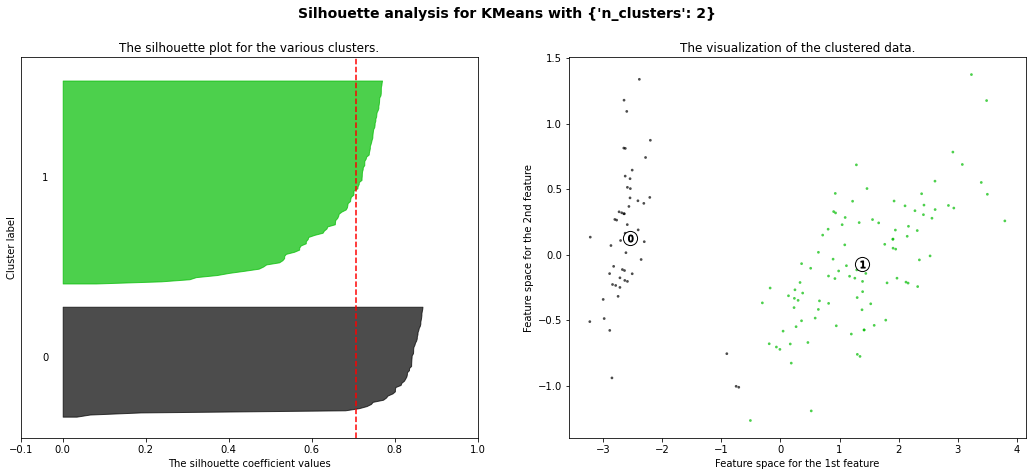

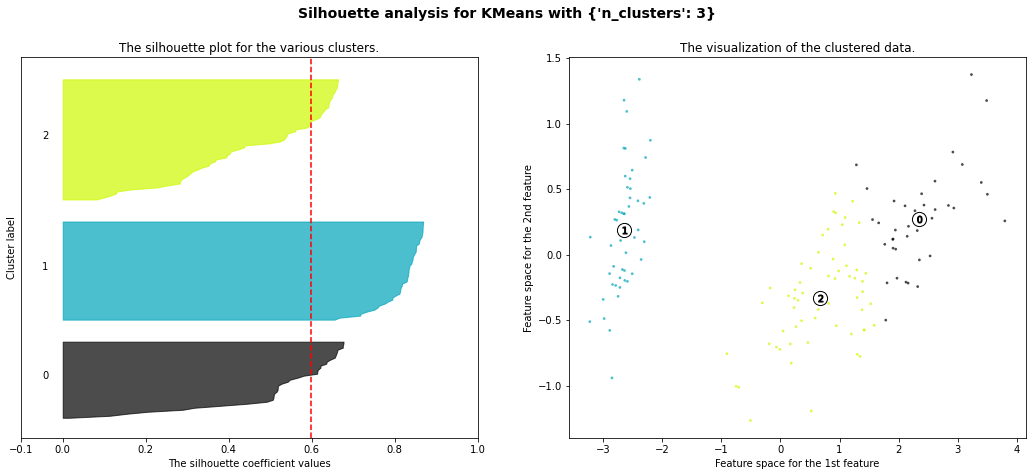

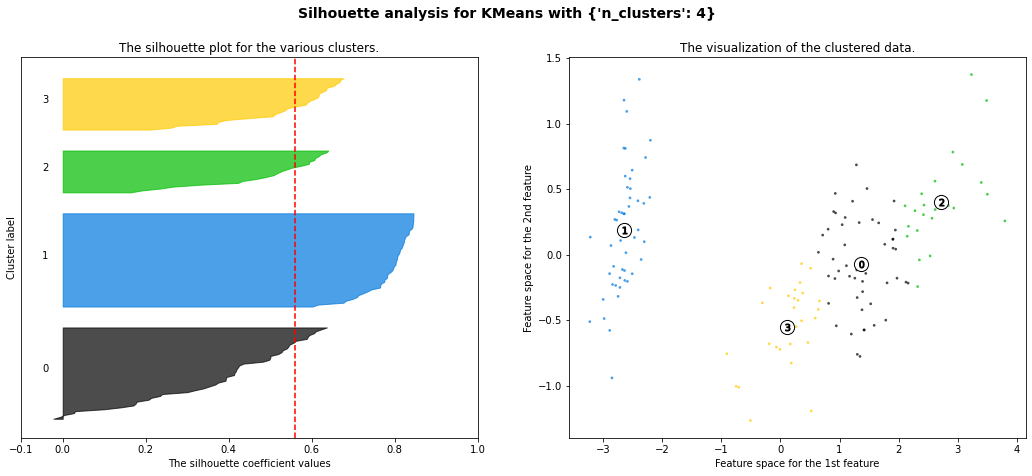

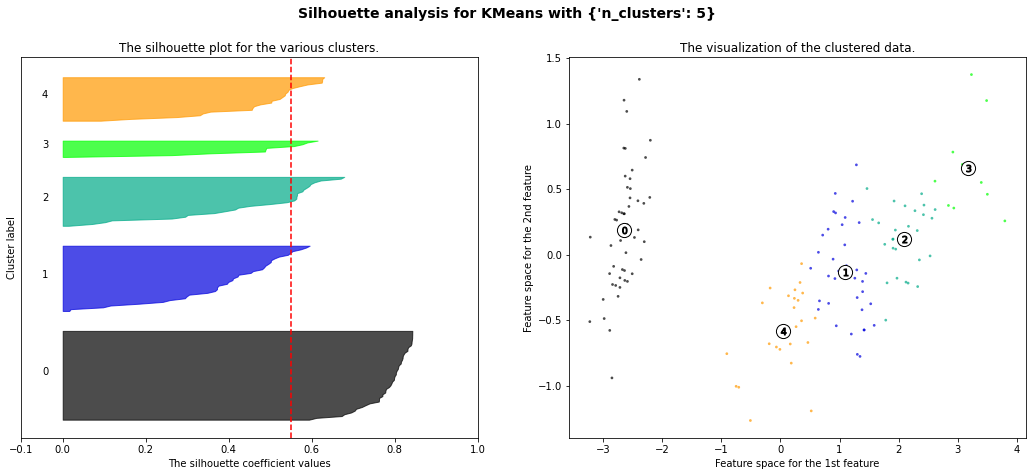

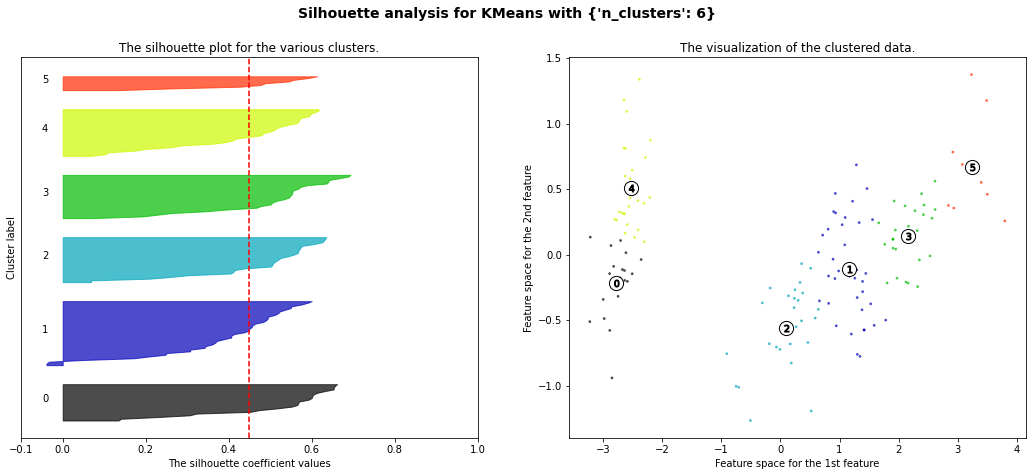

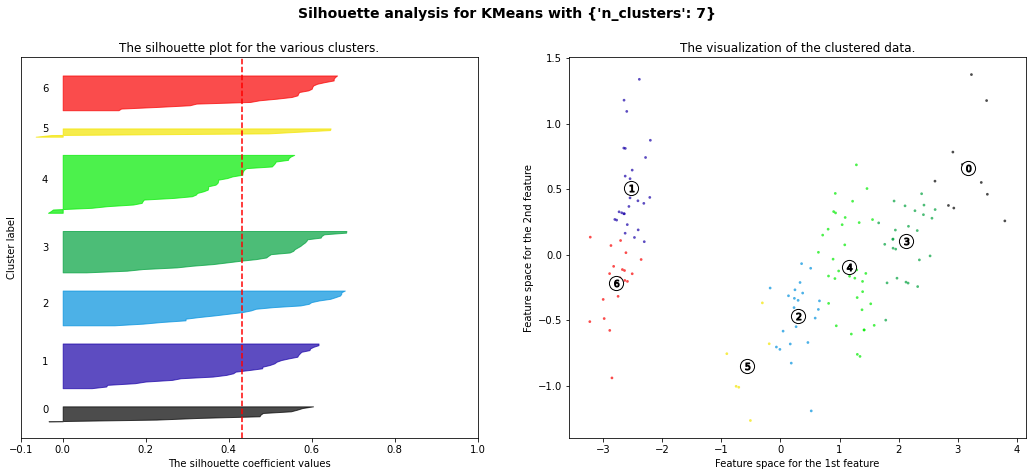

In [47]:
make_sklearn_sil_plots(iris_2d.values)


### En qué hay que fijarse en estos gráficos:

* El grosor de cada silueta indica el tamaño del cluster.
* La forma de cada silueta indica la "bondad" de los puntos de cada conglomerado.
La longitud (o área) de cada silueta indica la bondad de cada conglomerado.
> Una caída más lenta (más rectangular) indica que hay más puntos "felices" en su cluster.
Por ejemplo, con o por encima tenemos siluetas "gruesas".

También se puede trazar una puntuación global de la silueta para cada número de clusters.

**El índice global (sklearn.metrics.silhouette_score) es la media de todos los ejemplos.**

In [48]:
def plot_silhouette(x,kmeans_dict,w=11,h=5):
    s = [metrics.silhouette_score(x,km.labels_) for k, km in kmeans_dict.items() if k>1]
    plt.figure(figsize=(w,h))
    plt.plot([k for k in kmeans_dict if k>1], s);
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("s", fontsize=w)


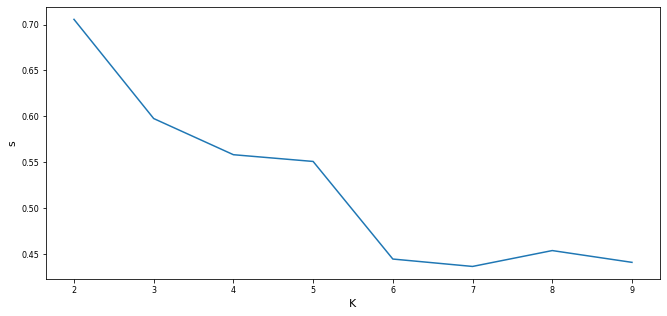

In [49]:
plot_silhouette(iris_2d.values,kmeans_sweep_iris)


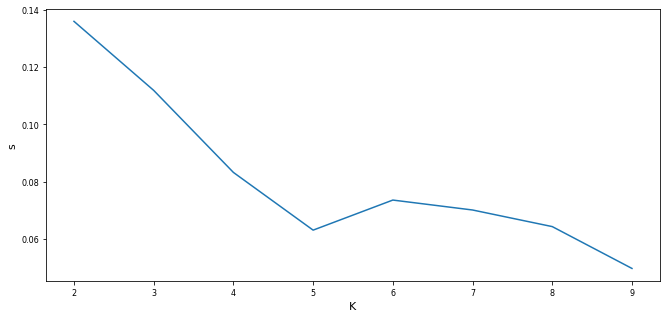

In [50]:
plot_silhouette(housing_df_enc,kmeans_sweep_housing)


For n_clusters = 2 The average silhouette_score is : 0.1359543529983618
For n_clusters = 3 The average silhouette_score is : 0.10799338466172359
For n_clusters = 4 The average silhouette_score is : 0.07777742578106475
For n_clusters = 5 The average silhouette_score is : 0.06327702819451528
For n_clusters = 6 The average silhouette_score is : 0.05731788572677824
For n_clusters = 7 The average silhouette_score is : 0.06680211088977779


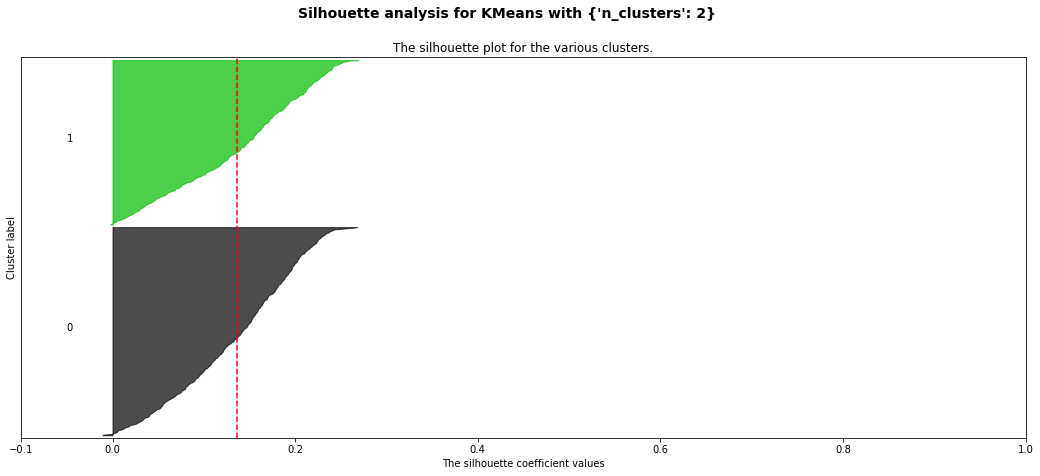

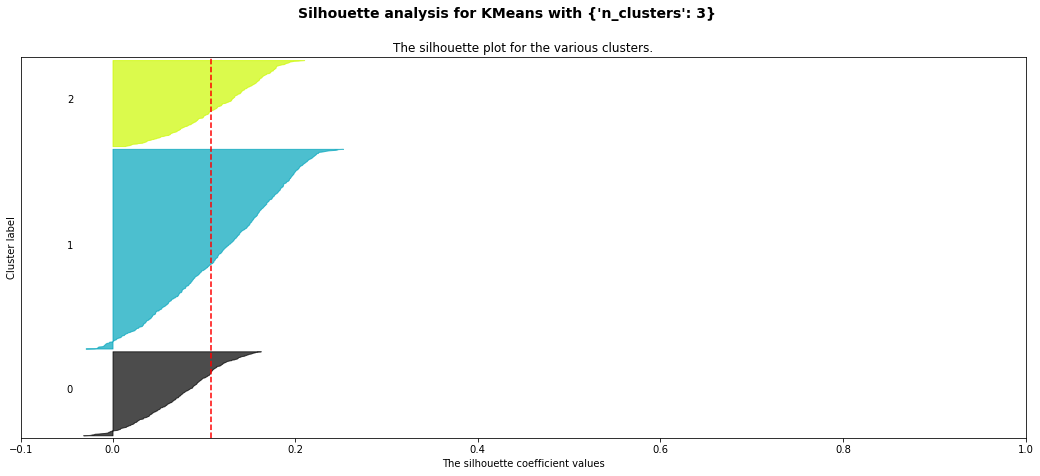

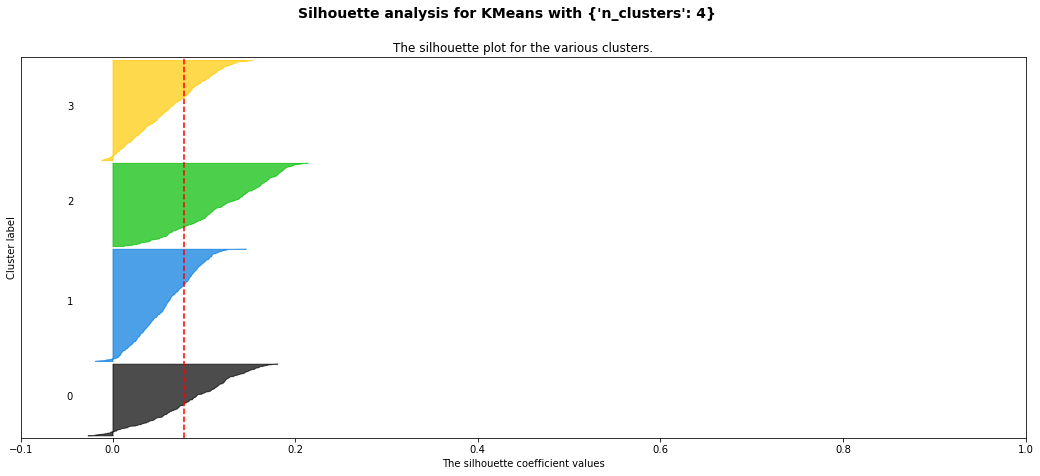

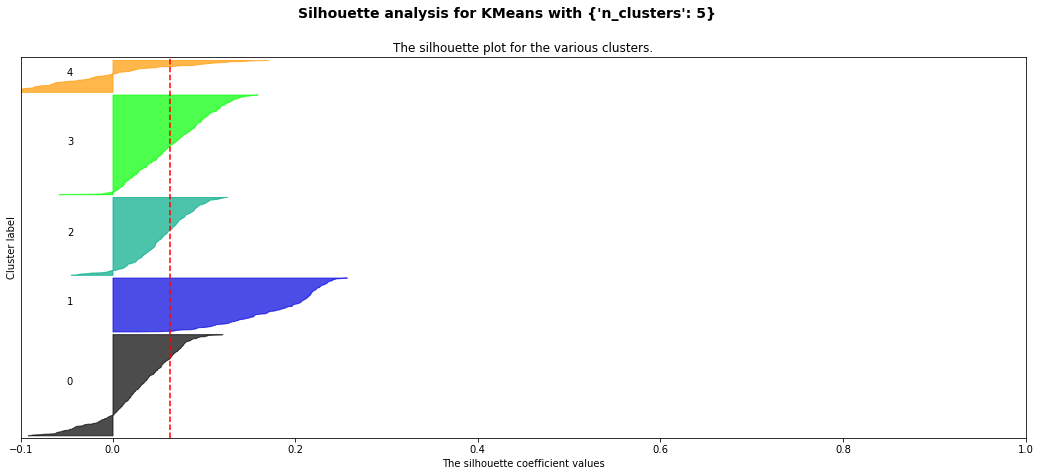

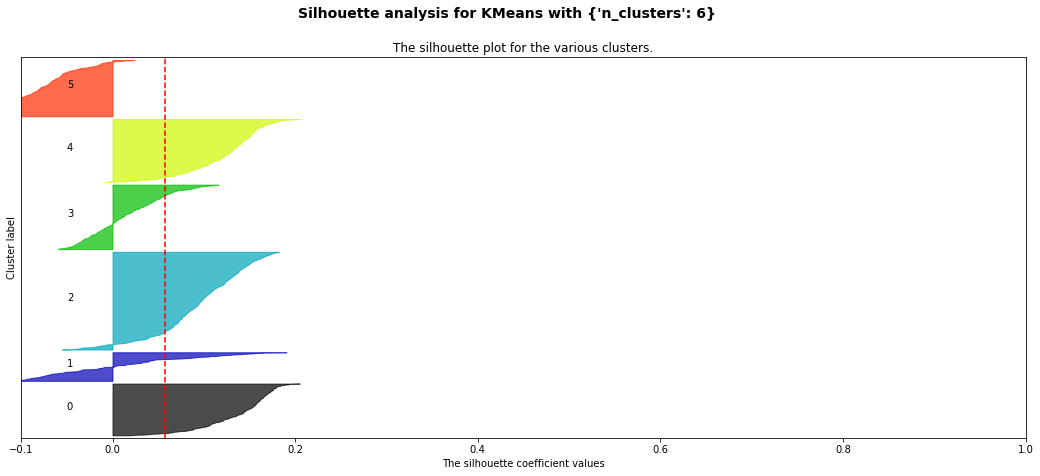

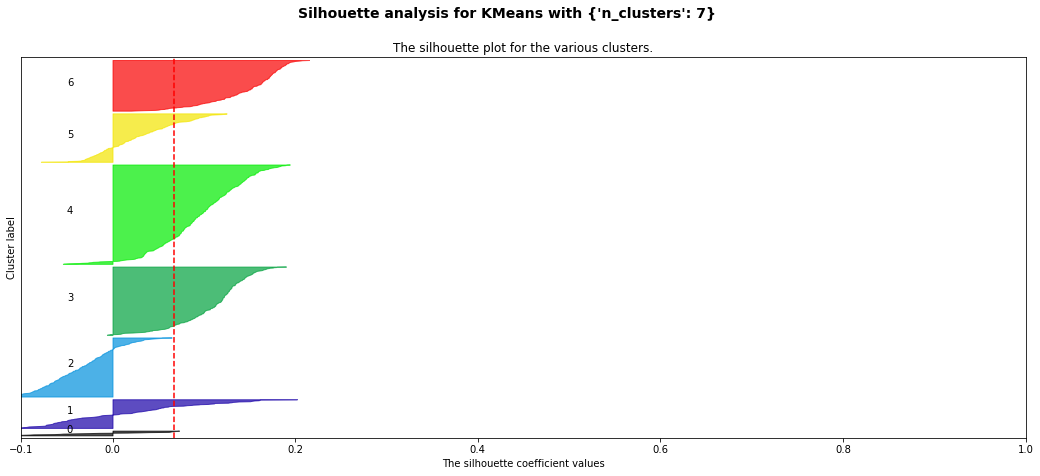

In [51]:
make_sklearn_sil_plots(housing_df_enc.values)


# DBSCAN

In [52]:
# collapse this cell

x1 = np.random.multivariate_normal(mean = [0,0], cov=np.diag([3,3]), size = 200)
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [-7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [7,-7], cov=np.diag([1,1]), size = 50)))
x1 = np.concatenate((x1,np.random.multivariate_normal(mean = [9,4], cov=np.diag([1,1]), size = 50)))

x2 = datasets.make_circles(n_samples=200, noise=.06, factor=.4)[0]

x3 = np.random.uniform(-1,1,size=100)
x3 = np.column_stack((x3,x3**3+np.random.normal(scale=.08,size=100)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [-1,1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.random.multivariate_normal(mean = [1,-1], cov=np.diag([.025,.025]), size = 50)))
x3 = np.concatenate((x3,np.column_stack((np.random.uniform(-2,2,size=20),np.random.uniform(-2,2,size=20)))))
datasets.make_blobs()

def plot_example_density(w,h):
    fig, ax = plt.subplots(1,3,figsize=(w,h))
    ax[0].scatter(x1[:,0],x1[:,1]);
    ax[1].scatter(x2[:,0],x2[:,1]);
    ax[2].scatter(x3[:,0],x3[:,1]);
    ax[0].set_title("How many clusters?", fontsize=w)
    ax[1].set_title("How many clusters?", fontsize=w)
    ax[2].set_title("How many clusters?", fontsize=w)

**Pregunta: ¿Cómo podemos saber cuántos clusters hay en los gráficos anteriores?**

Una definición es que, dentro de los clusters tenemos mayor densidad de puntos que fuera de los clusters;

***Trabajemos con la idea de densidad***

La idea atrás de usar la densidad es que para formar parte de un cluster, cada punto debe tener al menos un cierto número de vecinos en un radio determinado.

Para trabajar con esta idea, necesitamos tres cosas:



1. Definir cuántos puntos vecinos necesitamos.
2. El parámetro del tamaño del vecindario.
3. La forma del vecindario: estará definida por la métrica de distancia utilizada.

El clustering DBSCAN funciona así, y puede ajustarse a formas que $k$-means no puede.

No entraremos en los detalles (clasifica cada punto como "punto central" o "punto fronterizo"

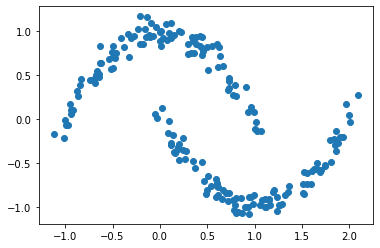

In [53]:
n1 = 100
x1 = np.linspace(-1,1,n1) + np.random.randn(n1)*.1
y1 = 1-x1**2 + np.random.randn(n1)*.1
n2 = 100
x2 = np.linspace(0,2,n2) + np.random.randn(n2)*.1
y2 = (x2-1)**2-1 + np.random.randn(n2)*.1
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
plt.scatter(x,y)
X = np.concatenate((x[:,None],y[:,None]),axis=1)

### La sintaxis de sklearn es diferente con DBSCAN 
- no hay método de predicción

- DBSCAN sólo agrupa realmente los puntos que tiene, no los puntos "nuevos" o "de prueba".

- A diferencia de k-means, DBSCAN no tiene que asignar todos los puntos a los clusters.

- La etiqueta es -1 si un punto no está asignado.

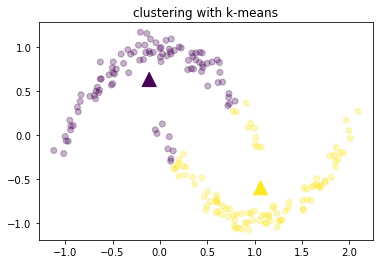

In [56]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
def plot_clust(X,W=None,z=None):
    if z is not None:
        if np.any(z<0):
            plt.scatter(X[z<0,0], X[z<0,1], marker="o", 
                        facecolors='none', edgecolor='black', alpha=0.3);
        if np.any(z>=0):
            plt.scatter(X[z>=0,0], X[z>=0,1], marker="o", c=z[z>=0], alpha=0.3);
    else:
        plt.scatter(X[:,0], X[:,1], marker="o", c='black', alpha=0.3);
    if W is not None:
        plt.scatter(W[:,0], W[:,1], marker="^", s=200, c=np.arange(W.shape[0]));
    else:
        plt.title("number of clusters = %d" % len(set(np.unique(z))-set([-1])));
        
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("clustering with k-means");

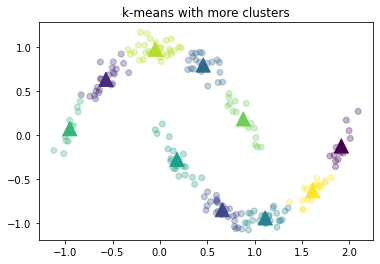

In [57]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)
plt.title("k-means with more clusters");

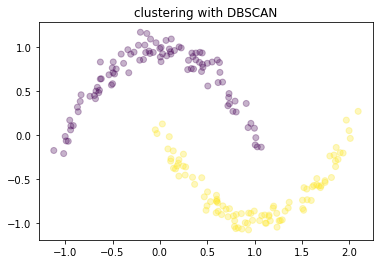

In [58]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)
plt.title("clustering with DBSCAN");

In [59]:
dbscan.labels_


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## Efecto de los hiperparametros para el DBScan


> Note que el número de clusters es una salida del modelo

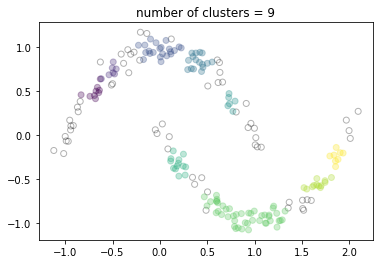

In [60]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

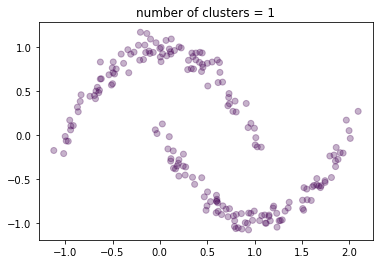

In [61]:
dbscan = DBSCAN(eps=1)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

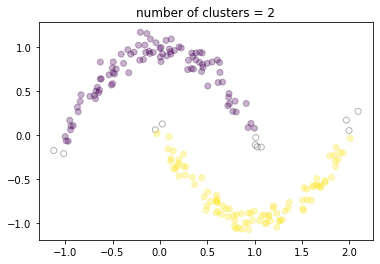

In [62]:
dbscan = DBSCAN(eps=0.5, min_samples=25)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

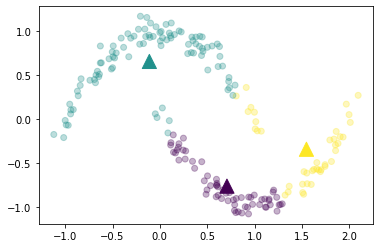

In [63]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
plot_clust(X,kmeans.cluster_centers_, kmeans.labels_)

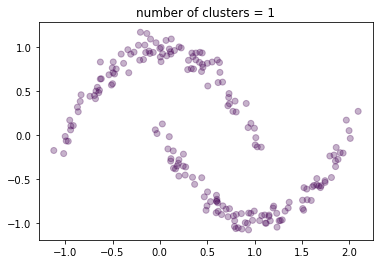

In [64]:
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan.fit(X)
plot_clust(X,z=dbscan.labels_)

# Clustering Jerárquico

En el agrupamiento aglomerativo, la formación del agrupamiento comienza con puntos individuales. Cada punto se considera como un grupo. Digamos que hay N puntos de datos. Al principio, habrá N grupos. Luego, se encuentra la distancia entre cada par de conglomerados y los conglomerados más cercanos entre sí se combinan y forman un solo conglomerado. Esto daría como resultado un clúster (N – 1). En el siguiente paso, se encuentra la distancia entre un par de grupos y los grupos más cercanos entre sí se combinan y forman un solo grupo. Esto daría como resultado (N – 2) grupos. El mismo proceso se repite hasta que todos los puntos de datos se fusionan en un grupo. por ejemplo, grupo raíz.

También se denomina agrupación jerárquica de abajo hacia arriba, ya que el proceso de agrupación comienza con un punto de datos individual y avanza hacia arriba para formar un grupo: el grupo raíz. En el siguiente diagrama, observe cómo se han formado los grupos a partir del nodo hoja y moviéndose hacia arriba.



El algoritmo de agrupación en clústeres jerárquicos aglomerativos difiere según el método de distancia utilizado para crear clústeres. Los siguientes son métodos de distancia comunes que se utilizan para crear clústeres:

1. Vínculo único : la distancia entre el grupo se determina en función de la distancia entre los dos puntos más similares en los dos grupos. En otras palabras, la distancia de dos puntos más cercana en dos grupos se usa para determinar la distancia del grupo.

2. Vínculo completo : la distancia entre el grupo se determina en función de la distancia entre dos puntos menos similares en los dos grupos. En otras palabras, la distancia de los dos puntos más lejanos en dos grupos se utiliza para determinar la distancia del grupo.

3. Centroide : la distancia entre el grupo se determina en función de la distancia entre el centroide de los dos grupos.

4. Enlace promedio : la distancia entre el grupo se determina en función de la distancia promedio entre todos los puntos en los dos grupos.

## Ejemplo de aplicación

In [11]:
?linkage


### Entender la salida de linkage

La función linkage devolverá una matriz $(n-1)x4$:

1. Primera y segunda columnas: índices de los clusters que se fusionan.

2. Tercera columna: la distancia entre los clusters que se fusionan.

3. Cuarta columna: el número de elementos en el nuevo cluster formado.

4. Las filas representan las iteraciones.

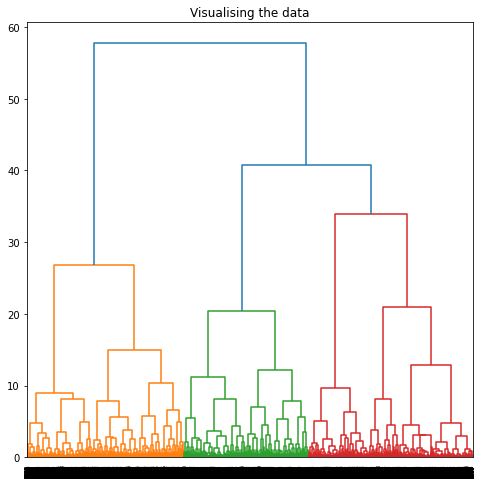

In [8]:

# Base de datos 


df = pd.read_csv("data/CC general.csv")

# Preprocesamiento muy básico 
# Eliminar una variable redundante, transformar otras e inputar perdidos
df = df.drop('CUST_ID', axis = 1)
df.fillna(method ='ffill', inplace = True)
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
df_normalized = normalize(df_scaled)


# Reducir la dimensionalidad usando PCA con 3 componentes
#
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_normalized)
df_pca = pd.DataFrame(df_pca)
df_pca.columns = ['P1', 'P2', 'P3']
#
# Create the Dendogram plot
#
plt.figure(figsize =(8, 8))
plt.title('Visualising the data')
dendrogram = dendrogram((linkage(df_pca, method ='ward',  metric='euclidean')))

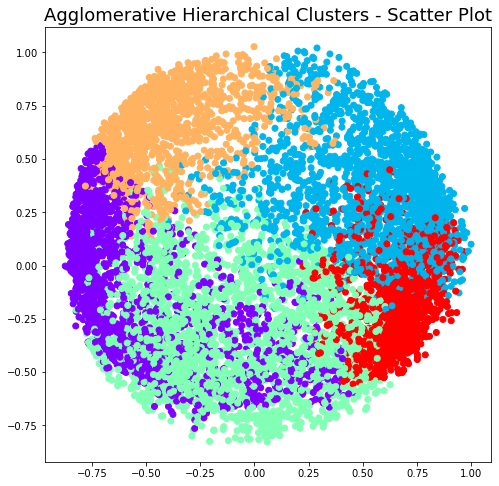

In [9]:
# Crear los clústeres utilizando la agrupación jerárquica aglomerativa de sk.learn.
# Observe que debe especificar el numero de clusters a diferencia del método anterior. 

agc = AgglomerativeClustering(n_clusters = 5)
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

In [ ]:
# para un número de 4 clusters 

agc = AgglomerativeClustering(n_clusters = 4)
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()

In [ ]:
# para un número de 3 clusters 


agc = AgglomerativeClustering(n_clusters = 3)
plt.figure(figsize =(8, 8))
plt.scatter(df_pca['P1'], df_pca['P2'], c = agc.fit_predict(df_pca), cmap ='rainbow')
plt.title("Agglomerative Hierarchical Clusters - Scatter Plot", fontsize=18)
plt.show()